# Scanner level identification result aggregation 
**to run this code, define dataset_name='SelfDeploy24' or 'SelfDeploy25'.**

In [1]:
dataset_name='SelfDeploy25'

**load configurations**

In [2]:
import pickle
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import numpy as np

for protocol in ['http','tls','dns']:
    if(dataset_name=='SelfDeploy24'):
        name='merge_month_2_4_2week'
        train_ensemble_dir='train_ensemble_batch64'   
    if(dataset_name=='SelfDeploy25'):
        name='selfdeploy_24_25_2week'   
        train_ensemble_dir='train_ensemble_selfdeploy25_batch64'     

proto_list=['http','tls','dns']
work_dir='IOMatch-main_per_service_total_sample'
time_window_list= [7]
mode='test'

interval 7


/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


0.36
test                  precision    recall  f1-score   support

     binaryedge       0.85      0.91      0.88       148
     criminalip       1.00      0.82      0.90        11
     cybergreen       1.00      1.00      1.00         1
           fofa       1.00      1.00      1.00         7
internet_census       1.00      0.94      0.97       124
     internettl       0.49      1.00      0.65        18
      intrinsec       1.00      1.00      1.00         2
           ipip       1.00      0.50      0.67         6
         onyphe       1.00      0.57      0.73        79
          quake       0.00      0.00      0.00         3
         rapid7       1.00      1.00      1.00         5
   shadowserver       0.99      0.55      0.71       282
         shodan       1.00      1.00      1.00        18
     stretchoid       0.91      0.97      0.94       793
            tum       0.00      0.00      0.00         1
        zoomeye       0.00      0.00      0.00         1
censys+driftnet     

/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


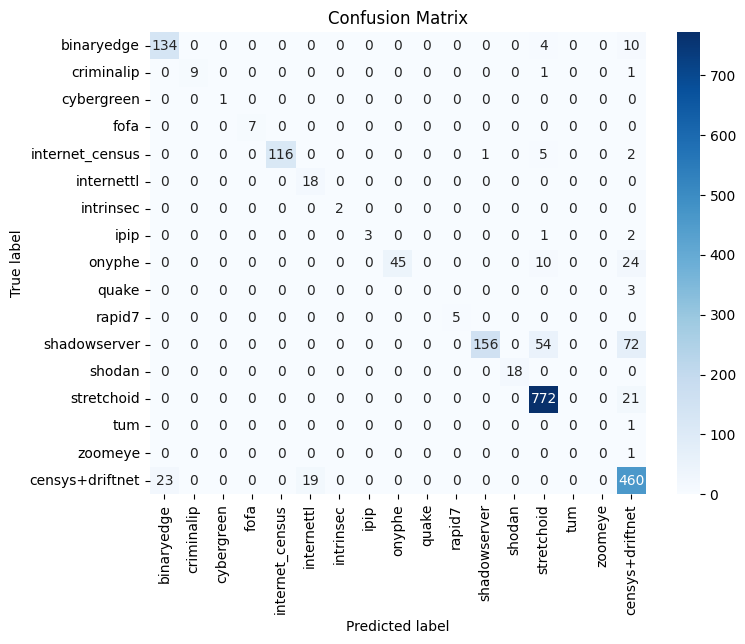

In [3]:
#ensemble learning
import pickle
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score
import numpy as np
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

def save_classification_report(y_true,y_pred,target_names,save_path):
    acc_report_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=target_names,output_dict=True,zero_division=np.nan)).T
    acc_report_df.iloc[-3,:2]= np.nan
    acc_report_df.iloc[-3,3]= acc_report_df.iloc[-2,3]
    acc_report_df.to_csv(save_path,float_format='%.3f')
    return acc_report_df.round(2)

use_train_threshold=1

for train_interval in time_window_list:    
    print('interval',train_interval)

    mode = 'train'
    for item in proto_list:
        with open(work_dir+'/'+'proto_level_'+str(train_interval)+'daysegment_pred_'+item+'_'+name+'_'+mode+'.pkl', 'rb') as file:
            data = pickle.load(file)
        if (item == 'http'):
            df_ip_http_group = data
        if (item == 'tls'):
            df_ip_tls_group = data
        if (item == 'dns'):
            df_ip_dns_group = data
        if(item=='rdp'):
            df_ip_rdp_group=data
        if(item=='ssh'):
            df_ip_ssh_group=data
        if(item=='smb'):
            df_ip_smb_group=data

    
    import os
    
    folder_path = work_dir+'/'+train_ensemble_dir+'/result_'+str(train_interval)+'day_segment_http'
    #Get all files starting with 'seg' in the folder    
    files = [f for f in os.listdir(folder_path) if f.startswith('seg') and f.endswith('.csv')]
    train_X_list = []
    train_y_list = []
    for file in files:
        if ('http' in proto_list):
            df_ip_http_train = df_ip_http_group[file]
        if ('tls' in proto_list):
            df_ip_tls_train = df_ip_tls_group[file]
        if ('dns' in proto_list):
            df_ip_dns_train = df_ip_dns_group[file]
        if ('ssh' in proto_list):
            df_ip_ssh_train=df_ip_ssh_group[file]
        if ('rdp' in proto_list):
            df_ip_rdp_train=df_ip_rdp_group[file]
        if ('smb' in proto_list):
            df_ip_smb_train=df_ip_smb_group[file]
    
        # Initialize an empty DataFrame for the merge
        merged_df = pd.DataFrame()
        
        # Iterate through the list of variables and merge the corresponding DataFrame
        for var in proto_list:
            # Use globals() to get the corresponding DataFrame based on a string.
            df_to_merge = globals()[f'df_ip_{var}_train']
            # Merging DataFrames using an outer join
            if merged_df.empty:
                merged_df = df_to_merge
            else:
                merged_df = pd.merge(merged_df, df_to_merge, how='outer')
            
        df_train_ip_merge=merged_df
        #print(df_train_ip_merge)
    
        train_X=df_train_ip_merge[['pred_label_' + var for var in proto_list]]

        train_y = np.array(df_train_ip_merge[['label']])
        train_X_list.append(train_X)
        train_y_list.append(train_y)

    train_X_all = pd.concat(train_X_list, ignore_index=True)
    train_y_all = np.concatenate(train_y_list, axis=0)
    train_X_all_cp=train_X_all.copy()
    train_y_all_cp=train_y_all.copy()
    
    mask = train_y_all < 25
    train_y_all = train_y_all[mask]
    train_X_all = train_X_all[mask]
    
    from sklearn.preprocessing import OneHotEncoder, LabelEncoder
    from sklearn.linear_model import LogisticRegression
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    label_list = ['adscore',
                  'ahrefs',
                  'arbor',
                  'archive',
                  'binaryedge',
    
                  'criminalip',
                  'cybergreen',
    
                  'fofa',
                  'internet_census',
                  'internettl',
                  'intrinsec',
                  'ipip',
                  'leakix',
                  'onyphe',
                  'quadmetrics',
                  'quake',
                  'rapid7',
                  'rau',
                  'shadowserver',
                  'shodan',
                  'stretchoid',
                  'tum',
                  'webRay',
                  'x_threatbook',
                  'zoomeye',
                  'driftnet(added in unknown)',
                  'unknown',
                  'censys(added in unknown)'
                  ]
    
    num_classes = 25
    open_mask = train_y_all >= num_classes
    train_y_all[open_mask] = num_classes
    
    #Delete the 26unknown class and convert the 25 and 27 label to 25
    value_to_delete = 26
    
    ans_train_y_all_cp = [item for list in train_y_all_cp.tolist() for item in list]
    mask_cp = np.array(ans_train_y_all_cp) != value_to_delete
    train_X_all_cp = train_X_all_cp[mask_cp]
    train_y_all_cp = train_y_all_cp[mask_cp]
    
    num_classes = 25
    open_mask = train_y_all_cp >= num_classes
    train_y_all_cp[open_mask] = num_classes
    
    
    onehot_en = OneHotEncoder(categories='auto', handle_unknown='infrequent_if_exist')  
    onehot_en = onehot_en.fit(train_X_all)
    
    train_X_all_onehot = onehot_en.transform(train_X_all)
    
    
    
    logreg = LogisticRegression(multi_class='ovr',class_weight ='balanced',max_iter=10000)  # Consider class balance
    logreg.fit(train_X_all_onehot, train_y_all)
    # load test set data
    mode = 'test'
    
    for item in proto_list:
        with open(work_dir+'/'+'proto_level_pred_'+item+'_'+name+'_'+mode+'.pkl', 'rb') as file:
            data = pickle.load(file)
        if (item == 'http'):
            df_ip_http_test = data
        if (item == 'tls'):
            df_ip_tls_test = data
        if (item == 'dns'):
            df_ip_dns_test = data
        if(item=='rdp'):
            df_ip_rdp_test=data
        if(item=='ssh'):
            df_ip_ssh_test=data
        if(item=='smb'):
            df_ip_smb_test=data

    merged_df = pd.DataFrame()
    for var in proto_list:
        df_to_merge = globals()[f'df_ip_{var}_test']
        if merged_df.empty:
            merged_df = df_to_merge
        else:
            merged_df = pd.merge(merged_df, df_to_merge, how='outer')
            
    df_test_ip_merge=merged_df
    
    test_X=df_test_ip_merge[['pred_label_' + var for var in proto_list]]
    test_y = np.array(df_test_ip_merge[['label']])
    test_ip=np.array(df_test_ip_merge[['ip']])
    test_X_onehot = onehot_en.transform(test_X)
    

    y_pred = logreg.predict(test_X_onehot)
    
    # output predict probabilities
    probs = logreg.predict_proba(test_X_onehot)
    probs_all=probs.copy()
    # #
    ans_test_y = [item for list in test_y.tolist() for item in list]
    ans_y_pred = y_pred 
    
    filtering = 1
    
    C = confusion_matrix(test_y, y_pred)
    
    value_to_delete = 26
    mask = np.array(ans_test_y) != value_to_delete
    
    num_classes = 25
    open_mask = test_y >= num_classes
    test_y[open_mask] = num_classes
    # filtered_test_y[open_mask] = num_classes
    
    filtered_test_y = test_y[mask]
    filtered_y_pred = y_pred[mask]
    filtered_test_ip = test_ip[mask]
    probs = probs[mask]
    # filtered_y_true_openset=filtered_y_true[open_mask]
    
    # process the predictions
    def process_predictions(probs, classes, threshold=0.5, unknown_label=25):
        predictions = []
        for prob in probs:
            max_prob = np.max(prob)
            if max_prob < threshold:
                predictions.append(unknown_label)
            else:
                predictions.append(classes[np.argmax(prob)])
        return predictions
    
    def find_best_threshold(probs, true_labels, classes, thresholds=np.arange(0.0, 1.1,0.01)):
        best_threshold = 0
        best_f1 = 0
    
        # Iterate through the different thresholds and calculate the F1 score
        for threshold in thresholds:
            final_predictions = process_predictions(probs, classes, threshold=threshold)
            test_f1 = f1_score(true_labels, final_predictions, average='weighted')  # 计算 F1 分数
    
            # Update the Optimal Threshold
            if test_f1 > best_f1:
                best_f1 = test_f1
                best_threshold = threshold
        return best_threshold, best_f1
    
    train_X_all_cp_onehot = onehot_en.transform(train_X_all_cp)
    probs_train = logreg.predict_proba(train_X_all_cp_onehot)
    
    if(use_train_threshold):
        best_threshold, best_f1 = find_best_threshold( probs_train, train_y_all_cp, logreg.classes_)
    else:
        best_threshold, best_f1 = find_best_threshold( probs, filtered_test_y, logreg.classes_)
    
    print(best_threshold)
    final_predictions = process_predictions(probs, logreg.classes_, threshold=best_threshold)
    final_predictions_defalut = process_predictions(probs, logreg.classes_, threshold=0.5)
    final_predictions_all = process_predictions(probs_all, logreg.classes_, threshold=best_threshold)

    
    index_list = list(set(ans_test_y) | set(ans_y_pred))
    label_list_new = []
    for item in index_list:
        label_list_new.append(label_list[item])
    
    filtered_test_y_new = [item for list in filtered_test_y.tolist() for item in list]
    index_list = list(set(filtered_test_y_new) | set(filtered_y_pred))
    label_list_new_new = []
    for item in index_list:
        label_list_new_new.append(label_list[item])
    

    index_list = list(set(filtered_test_y_new) | set(final_predictions))
    label_list_new_new_known_class = []
    for item in index_list:
        label_list_new_new_known_class.append(label_list[item])
    
    ##Processing test set prediction results
    print('test', classification_report(filtered_test_y, final_predictions,
                                        target_names=label_list_new_new_known_class[:-1] + ['censys+driftnet']))
    #print('train f1', best_f1)


    test_f1 = f1_score(filtered_test_y, final_predictions, average='weighted') 
    test_f1_defalut = f1_score(filtered_test_y, final_predictions_defalut, average='weighted') 
    print('interval',train_interval,'test_f1',"{:.3f}".format(test_f1))

    save_path='report/'+name+'_'+str(train_interval)+'.csv'
    acc_report_df = save_classification_report(filtered_test_y, final_predictions,target_names=label_list_new_new_known_class[:-1]+['censys+driftnet'],save_path=save_path)
    #print(acc_report_df)

    #print('test confusion_matrix')
    #print( confusion_matrix(filtered_test_y, final_predictions))


    
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix,classification_report
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(filtered_test_y, final_predictions), annot=True, cmap='Blues', fmt='g',xticklabels=label_list_new_new_known_class[:-1]+['censys+driftnet'],yticklabels=label_list_new_new_known_class[:-1]+['censys+driftnet'])#, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1']
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()


    

Best threshold test: 0.400, F1 Score: 0.866


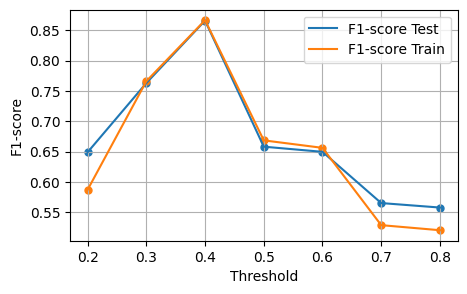

In [4]:
#eval identification performance with different threshold 
thresholds = np.arange(0.20, 0.81, 0.1)
f1_scores_train = []
f1_scores_test = []


for threshold in thresholds:
    # Generate Predictions on train set
    final_predictions_train = process_predictions(probs_train, logreg.classes_, threshold=threshold)
    train_f1 = f1_score(train_y_all_cp, final_predictions_train, average='weighted') 
    f1_scores_train.append(train_f1)
    # Generate Predictions on test set
    final_predictions = process_predictions(probs, logreg.classes_, threshold=threshold)#
    # Calculating F1 scores
    test_f1 = f1_score(filtered_test_y, final_predictions, average='weighted') 
    f1_scores_test.append(test_f1)

best_threshold_train = thresholds[np.argmax(f1_scores_train)]
best_threshold_test = thresholds[np.argmax(f1_scores_test)]
print(f"Best threshold test: {best_threshold_test:.3f}, F1 Score: {max(f1_scores_test):.3f}")

# draw line graphs
plt.figure(figsize=(5, 3))
plt.plot(thresholds, f1_scores_test, label='F1-score Test')
plt.plot(thresholds, f1_scores_train, label='F1-score Train')
plt.scatter(thresholds,f1_scores_test,  s=25, marker='o')
plt.scatter(thresholds,f1_scores_train,  s=25, marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# generate 128-dim feautre file
import pickle
print(len(test_ip))
new_test_ip=[]
for item in test_ip:
    new_test_ip.append(item[0])
ip_pred_dict = dict(zip(new_test_ip, final_predictions_all))

mode = 'test'
for item in proto_list:
    with open(work_dir+'/'+'packet_level_proj_'+item+'_'+name+'_'+mode+'.pkl', 'rb') as file:
        data = pickle.load(file)
    if (item == 'http'):
        dic_http = data
        #print(data['proj'][:3])
        index_array_http=np.load('dataset/npy/'+'index_'+item+'_'+name+'_'+mode+'.npy')
    if (item == 'tls'):
        dic_tls = data
        index_array_tls=np.load('dataset/npy/'+'index_'+item+'_'+name+'_'+mode+'.npy')
    if (item == 'dns'):
        dic_dns = data
        index_array_dns=np.load('dataset/npy/'+'index_'+item+'_'+name+'_'+mode+'.npy')

# Creating a DataFrame
df_http = pd.DataFrame(dic_http)
df_http['proto']='http'
df_http['index_original']=index_array_http
df_http['y_true_organization_name'] = [label_list[idx] for idx in df_http['y_true']]

df_tls = pd.DataFrame(dic_tls)
df_tls['proto']='tls'
df_tls['index_original']=index_array_tls
df_tls['y_true_organization_name'] = [label_list[idx] for idx in df_tls['y_true']]

df_dns = pd.DataFrame(dic_dns)
df_dns['proto']='dns'
df_dns['index_original']=index_array_dns
df_dns['y_true_organization_name'] = [label_list[idx] for idx in df_dns['y_true']]

#df_test_merge=pd.merge(df_http, df_tls,how='outer')
#df_test_merge=pd.merge(df_test_merge, df_dns,how='outer')
df_http['ip_pred']=''
df_tls['ip_pred']=''
df_dns['ip_pred']=''


for index, row in df_http.iterrows():
    df_http.loc[index, 'ip_pred'] = ip_pred_dict[row['ip']]

for index, row in df_tls.iterrows():
    df_tls.loc[index, 'ip_pred'] = ip_pred_dict[row['ip']]

for index, row in df_dns.iterrows():
    df_dns.loc[index, 'ip_pred'] = ip_pred_dict[row['ip']]

result = pd.concat([df_http, df_tls], axis=0, ignore_index=True)
result = pd.concat([result, df_dns], axis=0, ignore_index=True)
print(result)
result.to_csv('proj_'+dataset_name.lower()+'_withindex.csv', index=False)

7400
                                                    proj  packet_pred  y_true  \
0      [-0.4924554228782654, 0.16711688041687012, -0....            4       4   
1      [-0.4924554228782654, 0.16711688041687012, -0....            4       4   
2      [-0.5156661868095398, 0.24492496252059937, -0....            4       4   
3      [-0.4924554228782654, 0.16711688041687012, -0....            4       4   
4      [-0.4924554228782654, 0.16711688041687012, -0....            4       4   
...                                                  ...          ...     ...   
45137  [-0.20655469596385956, 0.23789134621620178, -2...            9      26   
45138  [-0.20655469596385956, 0.23789134621620178, -2...            9      26   
45139  [0.3118574917316437, -0.3995012044906616, -0.3...           25      26   
45140  [-0.20655469596385956, 0.23789134621620178, -2...            9      26   
45141  [-0.20655469596385956, 0.23789134621620178, -2...            9      26   

                   ip 